In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  
import locale
locale.setlocale(locale.LC_TIME, "pt_PT") # processar datas em PT
from datetime import timedelta
import os
import sys
sys.path.append('../src')
import aosol.series.consumo as series
import aosol.series.producao as seriesprod
import aosol.series.pvgis as pvgis
import aosol.analise.analise_energia as ae
import aosol.analise.analise_financeira as af
import aosol.analise.analise_precos_energia as ape
from aosol.armazenamento import bateria
from IPython.display import HTML, display, display_html

## Analise de UPAC com bateria

Analise de um projecto de UPAC com dados de consumo obtidos do portal e-redes, dados de produção obtidos da plataforma PVGIS e subsequente análise dos indicadores principais do projecto: indice auto consumo (IAC), indice de auto suficiência (IAS) e indice entrega à rede (IER). É feita também uma análise financeiro do projecto.

#### Indice:
##### 1. Consumo
##### 2. Produção
##### 3. Análise Energética Projecto
##### 4. Análise Poupança Anual
##### 5. Análise Financeiro Projecto

In [1]:
# Parametros do projecto
nome_projecto = 'Exemplo_600W'
# =====================
# Consumo
# =====================
ano_consumo = 2021
# Pasta com 12 ficheiros com o formato MM_YYYY.xlsx onde MM = [01, 12] e YYYY = ano_consumo
pasta_ficheiro_consumo = r"../../JoaoXXI-consumo/eredes/"

# =====================
# Producao
# =====================
capacidade_instalada = 0.6 # em kW
ano_producao = 2021 # converter as datas de producao para este ano
# Opcoes API PVGIS
ano_pvgis_db = 2020 # ultimo ano disponivel PVGIS-SARAH2 na V5.2
lat = 38.716
lon = -9.148
inclinacao = 30
azimute = 0.0 # azimute = 180 + x; 0 = Sul
perdas = 14 # %

# =====================
# Analise energetica
# =====================
analise_com_bateria = True
capacidade_bat = 1.2 # kWh
soc_min = 20 # limite maximo descarregamento em % 
soc_max = 80 # limite maximo carregamento em %

# =====================
# Analise poupanca anual
# =====================
ano_tarifario = 2022
simples_kwh = 0.15826 # simples
bihorario_fora_vazio_kwh = 0.1859
bihorario_vazio_kwh = 0.0988
trihorario_ponta_kwh = 0.2278
trihorario_cheias_kwh = 0.1638
trihorario_vazio_kwh = 0.0988
# venda a rede com preco fixo
preco_venda_rede = 0.06 # 6cent/kWh

# =====================
# Analise tempo de vida
# =====================
tempo_vida = 25 # anos
ano_0 = 2022 # ano 0 do projecto
taxa_actualizacao = 5 # em %
taxa_degradacao_sistema = 0.7 # %/ano

# Custos do projecto
total = 1500 # €
# investimento_estimado = pv + instalacao + outros_custos
custo_pv = total * 0.6 # 60% material
custo_instalacao = total * 0.3 # 30% instalacao
outros_custos = total * 0.1 # 10% outros custos
# custo manutencao anual como percentagem do investimento
perc_custo_manutencao = 0.5 # em %
# apoio estatal (fundo ambiental)
considerar_apoio = False
perc_apoio = 85 # em % do investimento estimado
apoio_max = 2500 # em €, valor maximo pago pelo fundo

### 1. Consumo

Utilização de dados medidos pela e-redes

In [4]:
consumo = series.leitura_ficheiros_mensais_medicao_eredes(pasta_ficheiro_consumo, ano_consumo)

Consumo anual = 2264.0 kWh


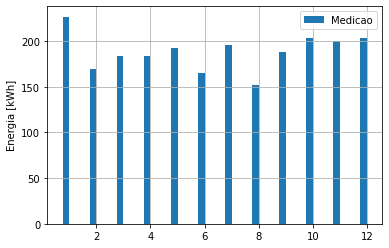

In [5]:
resultados_mensais = consumo['consumo'].resample('M').sum()

width = 0.25
plt.bar(resultados_mensais.index.month-width/2, resultados_mensais, width=width, label='Medicao')
plt.legend()
plt.ylabel('Energia [kWh]')
plt.grid()

print("Consumo anual = {:.1f} kWh".format(consumo['consumo'].sum()))

### 2. Produção

Produção estimada através do PV GIS

In [6]:
producao = pvgis.get_pvgis_hourly(lat, lon, ano_pvgis_db, ano_pvgis_db, surface_tilt=inclinacao, surface_azimuth=azimute, peakpower=capacidade_instalada, loss=perdas)
producao = seriesprod.converter_pvgis_data(producao, ano_producao)

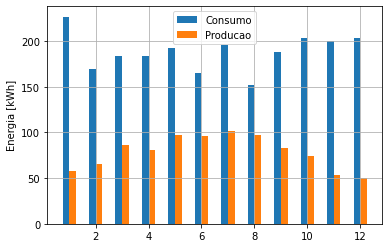

In [7]:
producao_mensal = producao.resample('M').sum()

width = 0.25
plt.bar(resultados_mensais.index.month-width/2, resultados_mensais, width=width, label='Consumo')
plt.bar(producao_mensal.index.month+width/2, producao_mensal['autoproducao'], width=width, label='Producao')
plt.legend()
plt.ylabel('Energia [kWh]')
plt.grid()

### 3. Análise Energético do Projecto

Considerar sistema de armazenamento com estado de carga (SOC) minimo de 20% e máximo de 80% para maximizar tempo de vida da bateria. 

In [8]:
energia_armaz = []

if analise_com_bateria:
    bat = bateria.bateria(capacidade_bat, soc_min, soc_max)

    # data frames com armazenamento
    energia_armaz = consumo['consumo'].to_frame('consumo')
    energia_armaz = energia_armaz.join(producao, how="outer")

    energia_armaz = ae.analisa_upac_com_armazenamento(energia_armaz, bat)

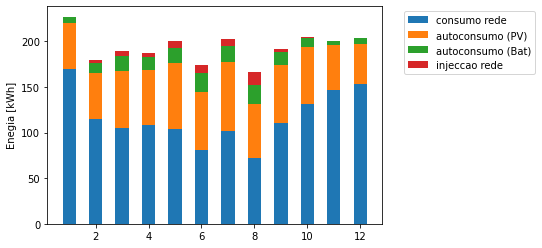

In [16]:
if analise_com_bateria:
    energia_armaz_mensal = energia_armaz.resample('M').sum()

    width = 0.5
    plt.bar(energia_armaz_mensal.index.month, energia_armaz_mensal["consumo_rede"], width=width, label='consumo rede')
    plt.bar(energia_armaz_mensal.index.month, energia_armaz_mensal["consumo_pv"], width=width, bottom=energia_armaz_mensal["consumo_rede"], label='autoconsumo (PV)')
    plt.bar(energia_armaz_mensal.index.month, energia_armaz_mensal["descarga_bateria"], width=width, bottom=energia_armaz_mensal["consumo_rede"]+energia_armaz_mensal["consumo_pv"], label='autoconsumo (Bat)')
    plt.bar(energia_armaz_mensal.index.month, energia_armaz_mensal["injeccao_rede"], width=width, bottom=energia_armaz_mensal["consumo_rede"]+energia_armaz_mensal["consumo_pv"]+energia_armaz_mensal["descarga_bateria"], label='injeccao rede')
    plt.legend(bbox_to_anchor=(1.05, 1.0))
    plt.ylabel('Enegia [kWh]')

In [10]:
if analise_com_bateria:
    indicadores_armaz = ae.calcula_indicadores_autoconsumo_com_armazenamento(energia_armaz, bat, capacidade_instalada)
    indicadores_armaz.print_html()

### 4. Análise de poupanca anual

Custos mensais por tipo tarifario.

#### 4.1 UPAC sem venda à rede

In [11]:
if analise_com_bateria:
    # custos tarifario simples
    tarifario_simples = lambda en, col: ape.calcula_tarifario_simples(en, simples_kwh, col)
    mensal_simples = af.analise_poupanca_anual(energia_armaz, tarifario_simples)
    simples_styler = mensal_simples.style.format("{:.2f} €").set_caption('Tarifario Simples').set_table_attributes("style='display:inline'")

    tarifario_bihorario = lambda en, col: ape.calcula_tarifario_bihorario_diario(en, bihorario_fora_vazio_kwh, bihorario_vazio_kwh, col)
    mensal_bihorario = af.analise_poupanca_anual(energia_armaz, tarifario_bihorario)
    bihorario_styler = mensal_bihorario.style.format("{:.2f} €").set_caption('Tarifario Bi-horário').set_table_attributes("style='display:inline'")

    tarifario_trihorario = lambda en, col: ape.calcula_tarifario_trihorario_diario(en, ano_tarifario, trihorario_ponta_kwh, trihorario_cheias_kwh, trihorario_vazio_kwh, col)
    mensal_trihorario = af.analise_poupanca_anual(energia_armaz, tarifario_trihorario)
    trihorario_style = mensal_trihorario.style.format("{:.2f} €").set_caption('Tarifario Tri-horário').set_table_attributes("style='display:inline'")
    display_html(simples_styler._repr_html_() + bihorario_styler._repr_html_() + trihorario_style._repr_html_(), raw=True)

,fatura sem upac,fatura com upac,poupanca
mes,,,
Janeiro,35.86 €,26.88 €,8.98 €
Fevereiro,30.13 €,19.72 €,10.41 €
Março,29.14 €,16.53 €,12.61 €
Abril,28.98 €,17.14 €,11.84 €
Maio,30.46 €,16.51 €,13.94 €
Junho,26.18 €,12.75 €,13.44 €
Julho,30.89 €,16.13 €,14.77 €
Agosto,24.00 €,11.35 €,12.65 €
Setembro,29.81 €,17.44 €,12.37 €


#### 4.2 UPAC com venda à rede

In [12]:
if analise_com_bateria:
    venda_rede = lambda en, col: ape.calcula_tarifario_simples(en, preco_venda_rede, col)
    # simples
    tarifario_simples = lambda en, col: ape.calcula_tarifario_simples(en, simples_kwh, col)
    mensal_simples = af.analise_poupanca_anual(energia_armaz, tarifario_simples, venda_rede)
    simples_styler = mensal_simples.style.format("{:.2f} €").set_caption('Tarifario Simples').set_table_attributes("style='display:inline'")

    tarifario_bihorario = lambda en, col: ape.calcula_tarifario_bihorario_diario(en, bihorario_fora_vazio_kwh, bihorario_vazio_kwh, col)
    mensal_bihorario = af.analise_poupanca_anual(energia_armaz, tarifario_bihorario, venda_rede)
    bihorario_styler = mensal_bihorario.style.format("{:.2f} €").set_caption('Tarifario Bi-horário').set_table_attributes("style='display:inline'")

    tarifario_trihorario = lambda en, col: ape.calcula_tarifario_trihorario_diario(en, ano_tarifario, trihorario_ponta_kwh, trihorario_cheias_kwh, trihorario_vazio_kwh, col)
    mensal_trihorario = af.analise_poupanca_anual(energia_armaz, tarifario_trihorario, venda_rede)
    trihorario_style = mensal_trihorario.style.format("{:.2f} €").set_caption('Tarifario Tri-horário').set_table_attributes("style='display:inline'")
    display_html(simples_styler._repr_html_() + bihorario_styler._repr_html_() + trihorario_style._repr_html_(), raw=True)

,fatura sem upac,fatura com upac,poupanca,venda a rede
mes,,,,
Janeiro,35.86 €,26.88 €,9.00 €,0.02 €
Fevereiro,34.46 €,22.87 €,11.73 €,0.14 €
Março,29.14 €,16.53 €,12.93 €,0.32 €
Abril,28.98 €,17.14 €,12.09 €,0.25 €
Maio,30.46 €,16.51 €,14.44 €,0.50 €
Junho,26.18 €,12.75 €,13.94 €,0.50 €
Julho,30.89 €,16.13 €,15.19 €,0.42 €
Agosto,24.00 €,11.35 €,13.51 €,0.86 €
Setembro,29.81 €,17.44 €,12.59 €,0.22 €


## 5. Analise Financeira do projecto no tempo de vida

Calcular indicadores financeiros para o tempo de vida do projecto.

* VAL

* TIR

* Tempo retorno projecto

In [13]:
investimento_estimado = custo_pv + custo_instalacao + outros_custos

# Custo de manutencao anual
custo_manutencao = investimento_estimado * (perc_custo_manutencao / 100)

# Apoio fundo ambiental
apoio = 0
if considerar_apoio:
   apoio = min(investimento_estimado*(perc_apoio/100), apoio_max)
   investimento_estimado = investimento_estimado - apoio

#### 5.1 UPAC sem venda à rede

In [15]:
# custos tarifario simples
tarifario_simples = lambda en, ano, col: ape.calcula_tarifario_simples(en, simples_kwh, col)
indicadores_financas_simples, cf_simples = af.analise_financeira_projecto(energia_armaz, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, tarifario_simples, indicadores_armaz)
simples_style = indicadores_financas_simples.as_frame().style.format("{:.2f}").set_caption('Tarifario Simples').set_table_attributes("style='display:inline'")

# custos tarifario bi-horario
tarifario_bihorario = lambda en, ano, col: ape.calcula_tarifario_bihorario_diario(en, bihorario_fora_vazio_kwh, bihorario_vazio_kwh, col)
indicadores_financas_bihorario, _ = af.analise_financeira_projecto(energia_armaz, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, tarifario_bihorario, indicadores_armaz)
bihorario_style = indicadores_financas_bihorario.as_frame().style.format("{:.2f}").set_caption('Tarifario Bi-horário').set_table_attributes("style='display:inline'")

# custos tarifario tri-horario
tarifario_trihorario = lambda en, ano, col: ape.calcula_tarifario_trihorario_diario(en, ano, trihorario_ponta_kwh, trihorario_cheias_kwh, trihorario_vazio_kwh, col)
indicadores_financas_trihorario, _ = af.analise_financeira_projecto(energia_armaz, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, tarifario_trihorario, indicadores_armaz)
trihorario_style = indicadores_financas_trihorario.as_frame().style.format("{:.2f}").set_caption('Tarifario Tri-horário').set_table_attributes("style='display:inline'")

display_html(simples_style._repr_html_() + bihorario_style._repr_html_() + trihorario_style._repr_html_(), raw=True)

,valores
indice,
Tempo vida util projecto [anos],25.00
Custo instalação [€],1500.00
Custo manutenção anual [€/ano],7.50
VAL [€],219.33
TIR [%],6.47
Retorno do investimento [anos],19.10
Lcoe [€/kWh],0.13
,valores
indice,
